## Gaussian Mixture ##

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal as Nd

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

A Gaussian mixture is a [mixture distribution](https://en.wikipedia.org/wiki/Mixture_distribution) of $d$ normal  distributions. 

A multivariate normal distribution is defined in  `scipy.stats`  as : V=Nd(mean=m, cov=Sigma), where $m=(m[0,], m[1], \ldots m[d-1])^T$ is the vector of means, and  $\Sigma\in\mathbb{R}^{d\times d}$, the covariance matrix.

We define a mixture of 4 bivariate normal distributions. For each bivariate distribution we set the mean vector, 
the standard deviation vector and the correlation coefficient of the corresponding random variables associated to that bivariate distribution:

In [5]:
pr=[0.2, 0.4, 0.15, 0.25]# the list of probabilities defining the Gaussian mixture
means=np.array([[0.5, 1.], [0.9, 2.7], [2., 3.],[2.5, 2]])
sigmas=np.array([[0.7, 0.6],   [0.7, 0.9],  [0.41, 0.23 ],[0.53, 0.35]]) # pairs of standard deviations
rho=np.array([0.0, -0.67,-0.76,0.5])# coefficients of correlation

In [6]:
def Covariance(m, sigma, r):# defines the covariance matrix matrix for a a normal bivariate  (X,Y)~N(m,Sigma)
    covar= r*sigma[0]*sigma[1]
    return np.array([[sigma[0]**2, covar], [covar, sigma[1]**2]])  
    

The four covariance matrices are stored in a 3D `numpy.array`, `Sigma`:

In [7]:
Sigma=np.zeros((2,2,4), float)
#Sigma[:,:, k] is the covariance matrix of the (k+1)^{th} bivariate normal distribution of  the mixture

for k in range(4):
    Sigma[:,:,k]=Covariance(means[k, :], sigmas[k,:], rho[k])
    

`mixtureDensity` defines the probability density function of the Gaussian mixture:

In [8]:
def mixtureDensity(x,y, pr, means, Sigma):
    pos=np.empty(x.shape + (2,))# if  x.shape is (m,n) then  pos.shape is (m,n,2)
    pos[:, :, 0] = x; pos[:, :, 1] = y 
    z=np.zeros(x.shape)
    for k in range(4) :
        z=z+pr[k]*Nd.pdf(pos, mean=means[k,:], cov=Sigma[:,:, k])
    return z     

The 3D `numpy.array`, pos, is defined in concordance to the  definition in `scipy.stats` of a 
[multivariate normal distribution](http://docs.scipy.org/doc/scipy-dev/reference/generated/scipy.stats.multivariate_normal.html). 

### Matplotlib plot of the Gaussian mixture probability density function ###

In [10]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)

We define a custom colormap to plot the mixture's pdf:

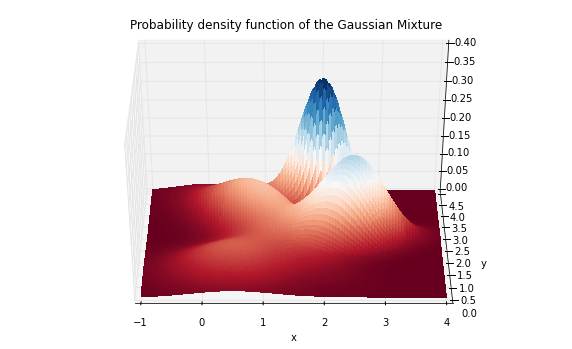

In [12]:
xx=np.linspace(-1, 4, 100)
yy=np.linspace(0, 4.5, 100)
x,y=np.meshgrid(xx,yy)
z=mixtureDensity(x, y, pr,  means, Sigma)

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Probability density function of the Gaussian Mixture')
ax.view_init(elev=35, azim=-90)
ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.RdBu,
        linewidth=0, antialiased=False)

### Plotly plot of the probability density function of the Gaussian mixture ###

To see this surface from different points of view we generate an interactive 
   Plotly plot:

In [13]:
mountain_cs=[[0.0, '#32924c'], # a custom colorscale 
 [0.1, '#52a157'],
 [0.2, '#74b162'],
 [0.3, '#94c06d'],
 [0.4, '#b6d079'],
 [0.5, '#d7de84'],
 [0.6, '#c9c370'],
 [0.7, '#bba65b'],
 [0.8, '#ad8a47'],
 [0.9, '#9f6d32'],
 [1.0, '#91511e']]

In [14]:
import plotly.plotly as py
from plotly.graph_objs import *

In [15]:
trace1= Surface(
       z=z,
       x=x,
       y=y, 
       colorscale=mountain_cs
    )

In [17]:
axis = dict(
showbackground=True, 
backgroundcolor="rgb(230, 230,230)",
gridcolor="rgb(255, 255, 255)",      
zerolinecolor="rgb(255, 255, 255)",  
    )

layout = Layout(
         title="" , 
         autosize=False,
         width=600,
         height=500,
         scene=Scene(  
             xaxis=XAxis(axis),
             yaxis=YAxis(axis),
             zaxis=ZAxis(axis), 
            )
        )

fig = Figure(data=[trace1], layout=layout)
py.sign_in('empet', 'my_api_key')
py.plot(fig, filename='Gaussian-Mixture-P-Distrib', world_readable=True)

u'https://plot.ly/~empet/4133'

### Contour plot and a cloud of points as a sample from the Gaussian mixture ###

In [26]:
trace2 =Contour(
        z=z,
        x=xx,
        y=yy,
        colorscale='Greens',
        reversescale=True,
        showlegend=False,
        showscale=False,
        contours=Contours(
            showlines=False) 
        )

### Sampling from the Gaussian mixture ###

The pseudocod to simulate a mixture distribution of pdf $f=p_0f_0+p_1f_1+\cdots+p_{d-1}f_{d-1}$, $\sum_{k=0}^{d-1}p_k=1$, is as follows:
    
`for n in range(N):`    
- do generate a value from the discrete distribution of mass function $p_X(k)=p_k$, $k=0,1, \ldots d-1$. Let j be the returned value;
- simulate the probability distribution of pdf $f_j$; let $pt$ be the returned point;
- append $pt$  to the list of points;

In [27]:
def  GaussianMixture2D(N, pr, means, Sigma):
    dis=np.random.choice([0, 1, 2, 3], size=N, p=pr)#generates  N values from the discrete distribution

    pts=np.empty((N,2), dtype=float)
    n=len(pr)
    for k in range(n):
        I=[j for j in range(N) if dis[j] == k]# list of  elements indexes  equal to  k (k=0, 1,  ..., n-1) 
        d=len(I)
        ptsk=Nd.rvs(size=d, mean=means[k], cov=Sigma[:,:,k])# sampling from $k^{th$} bivariate distribution 
        pts[I,:]=ptsk # insert these values in positions stored by  I 
    return zip(dis,pts)

In [28]:
N=4000
pts=GaussianMixture2D(N, pr, means, Sigma)

In a subplot of two rows and one column we plot the contour of the mixture density function and the cloud of points resulted from mixture simulation.

In [29]:
import plotly.plotly as py
from plotly.graph_objs import *


In [40]:
cols=['#e6b3d1',  '#b3e6b8',  '#d0d025', '#c27070']# color of points generated from each mixture's 
                                                   # component distribution

In [31]:
color=[]
X=[]
Y=[]
for idx, pt in pts:
    color.append(cols[idx])
    X.append(pt[0])
    Y.append(pt[1])

In [32]:
trace3 = Scatter(
    x=X,
    y=Y,
    mode='markers',
    name='',
    marker=Marker(
        color=color,
        size=4,
        symbol='dot',
        line=Line(
            color='#000000',
            width=0.5
        ),
     opacity=0.8   
    ),

)

In [33]:
from plotly import tools

In [39]:
fig = tools.make_subplots(rows=2, cols=1,
    subplot_titles=('Contour plot of a Gaussian mixture', 'Sampling from the above Gaussian mixture'),
    vertical_spacing=0.075)   

set_axis1=dict(showgrid=False, ticks='', autotick=False, showticklabels=False)
set_axis2=dict(showgrid=False,
          zeroline=False,
          showline=True,
          mirror=True, 
          ticks='outside')

fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 2, 1)
fig['layout']['xaxis1'].update(set_axis1)
fig['layout']['yaxis1'].update(set_axis1)
fig['layout']['xaxis2'].update(set_axis2, title='x')
fig['layout']['yaxis2'].update(set_axis2, title='y' )
fig['layout'].update(width=500,
                     height=800,
                     showlegend=False,
                     hovermode='closest',)

py.iplot(fig, filename='Gaussian-mixture-sbplts')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [35]:
from IPython.core.display import HTML
def  css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()